In [1]:
"""
Notebook normalization – SWT Python 3.11 package

Goal:
Develop an adaptive indexing approach that leverages the matrix profile
on unevenly sampled, multivariate time series, using variable window lengths
tailored to local sampling density and signal behavior.
"""

# ---- Package imports ----

# Numerical computation
import numpy as np
#Manipulate row data format
import h5py as hp
# Data manipulation
import pandas as pd

# DTW and Soft-DTW distance functions for time series
from tslearn.metrics import dtw, soft_dtw

# Matrix Profile for pattern discovery and anomaly detection
import stumpy

# FAISS for fast vector indexing and similarity search
import faiss

# Plotting
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error


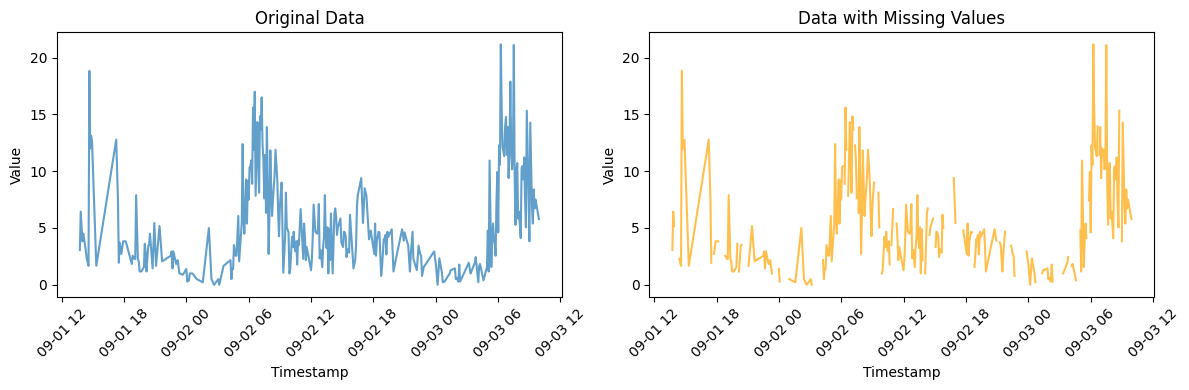

                     value
timestamp                 
2015-09-01 13:45:00   3.06
2015-09-01 13:50:00   6.44
2015-09-01 13:55:00   5.17
2015-09-01 14:00:00   3.83
2015-09-01 14:05:00   4.50


In [2]:
""" import of Dataset """
# occupancy of the Twin Cities Metro area in Minnesota
df = pd.read_csv('../../dataset/occupancy_6005.csv')
df = df.iloc[0:300]
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)

df_missing = df.copy()
#Introduce 15% missing data
missing_indices = np.random.choice(df_missing.index, size=int(0.15 * len(df_missing)), replace=False)
df_missing.loc[missing_indices, "value"] = np.nan

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# First Subplot : original data
ax1.plot(df['value'], label='Original', alpha=0.7)
ax1.set_title("Original Data")
ax1.set_xlabel("Timestamp")
ax1.set_ylabel("Value")
ax1.tick_params(axis='x', rotation=45)

# Second subplot : missing data
ax2.plot(df_missing['value'], label='Missing Data', color='orange', alpha=0.7)
ax2.set_title("Data with Missing Values")
ax2.set_xlabel("Timestamp")
ax2.set_ylabel("Value")
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()
print(df.head())

RMSE for each interpolation :
linear      : 1.0847
time        : 1.0874
nearest     : 1.1062
pad         : 1.1390
spline      : 1.2411
bfill       : 1.2535
polynomial  : 1.4119


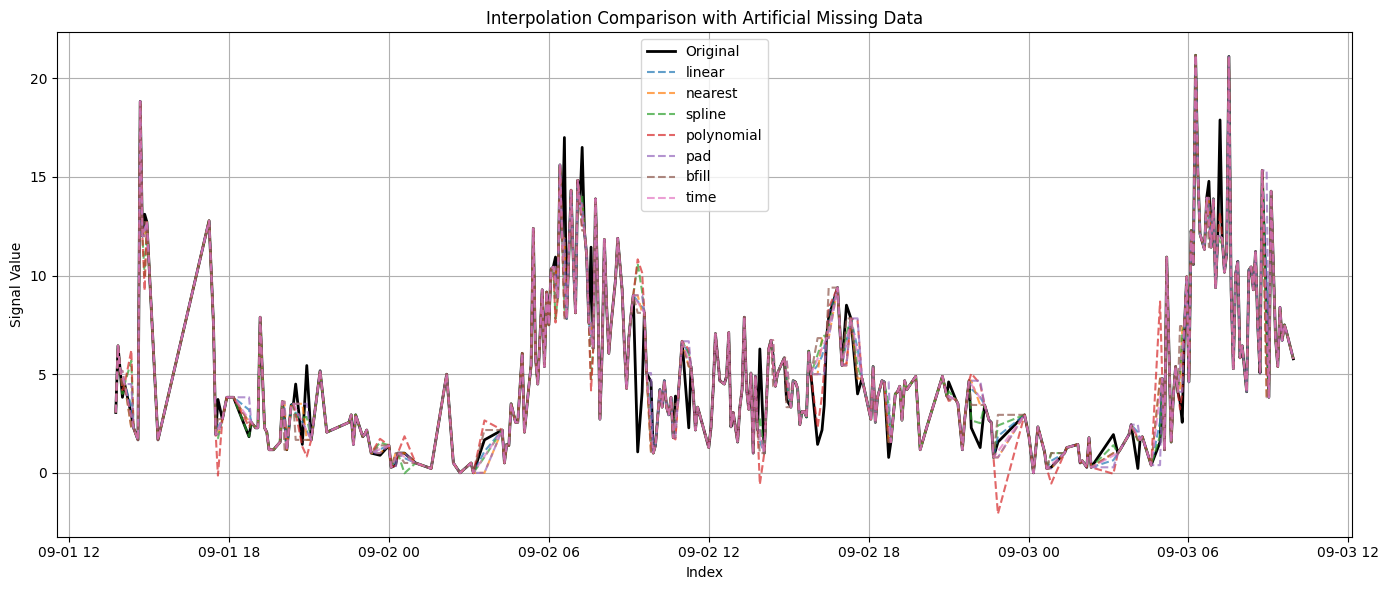

In [3]:
# Method to test
methods = ["linear", "nearest", "spline", "polynomial", "pad", "bfill", "time"]

# Apply interpolations
for method in methods:
    try:
        if method in ["spline", "polynomial"]:
            df_missing[method] = df_missing["value"].interpolate(method=method, order=3)
        elif method == "pad":
            df_missing[method] = df_missing["value"].ffill()
        elif method == "bfill":
            df_missing[method] = df_missing["value"].bfill()
        elif method == "time":
            df_missing[method] = df_missing["value"].interpolate(method="time")
        else:
            df_missing[method] = df_missing["value"].interpolate(method=method)
    except Exception as e:
        print(f" Méthode '{method}' échouée : {e}")
        df_missing[method] = np.nan

# Calculate of RMSE
rmse_results = {}
for method in methods:
    valid = df["value"].notna() & df_missing[method].notna()
    rmse = np.sqrt(mean_squared_error(df.loc[valid, "value"], df_missing.loc[valid, method]))
    rmse_results[method] = rmse

# Show results
print("RMSE for each interpolation :")
for method, rmse in sorted(rmse_results.items(), key=lambda x: x[1]):
    print(f"{method:<12}: {rmse:.4f}")

# graphic result
plt.figure(figsize=(14, 6))
plt.plot(df["value"], label="Original", color="black", linewidth=2)
for method in methods:
    plt.plot(df_missing[method], label=method, linestyle="--", alpha=0.7)
plt.title("Interpolation Comparison with Artificial Missing Data")
plt.xlabel("Index")
plt.ylabel("Signal Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Why Linear Interpolation Performs Well

Among the different interpolation methods tested, **linear interpolation** shows one of the lowest RMSE values and achieves a good visual fit compared to the original signal.

#### Advantages:
- **Simplicity**: Linear interpolation connects known points with straight lines, which makes it computationally efficient and easy to understand.
- **Smooth enough for small gaps**: In our test, with moderate noise and relatively smooth signal transitions, the linear segments approximated the ground truth well.
- **No overfitting**: Unlike polynomial or spline interpolation, linear interpolation avoids artificial oscillations or exaggerated peaks between missing values.
- **Robust to local fluctuations**: Linear interpolation doesn't amplify local noise, which keeps the signal behavior realistic.

#### When It Might Fail:
- For signals with high-frequency components or rapid non-linear changes, linear interpolation might **miss curvature**.
- For **long gaps**, the assumption of constant slope might oversimplify transitions.

Overall, **linear interpolation is a strong general-purpose method**, especially for **smooth, low-noise time series** like the one tested here.


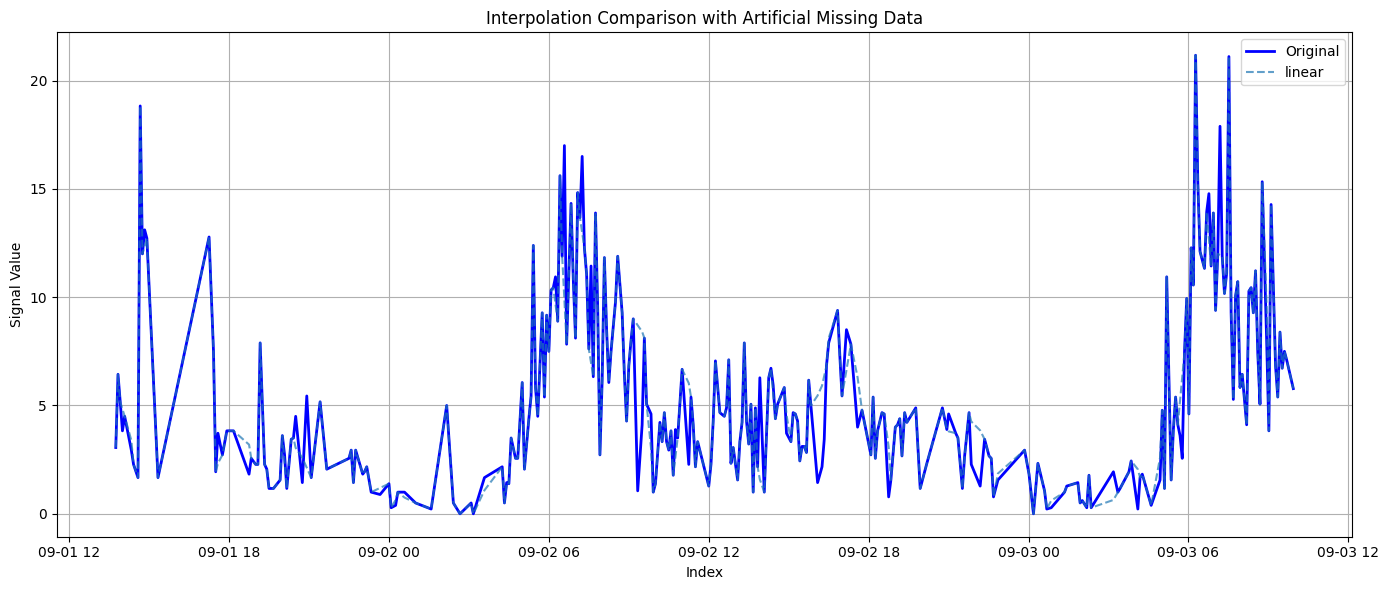

In [4]:
# graphic result
plt.figure(figsize=(14, 6))
plt.plot(df["value"], label="Original",color="blue", linewidth=2)
plt.plot(df_missing["linear"], label="linear",  linestyle="--", alpha=0.7)
plt.title("Interpolation Comparison with Artificial Missing Data")
plt.xlabel("Index")
plt.ylabel("Signal Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [5]:
# 1. Create a regular timestamp index (e.g., every minute)
regular_index = pd.date_range(
    start=df_missing.index.min(),
    end=df_missing.index.max(),
    freq='1min'  # adjust if needed: '5min', '10min', etc.
)

# 2. Reindex the DataFrame to introduce missing timestamps (set them as NaN)
df_linear = df_missing[['value']].reindex(regular_index)

# 3. Apply linear interpolation to fill the missing values
df_linear['linear'] = df_linear['value'].interpolate(method='linear', limit_direction='both')

# 4. Keep only the interpolated column and clean up the original DataFrames
# (drop the original 'value' and auxiliary interpolation columns if they exist)
df_linear = df_linear.drop(columns='value').rename(columns={'index': 'timestamp'})
df_missing = df_missing.drop(columns=['value', 'nearest', 'spline', 'polynomial', 'pad', 'bfill', 'time']).rename(columns={'index': 'timestamp'})

# 5. Display a few rows from each DataFrame for verification
print(df_linear.head(6))
print(df_missing.head(2))


                     linear
2015-09-01 13:45:00   3.060
2015-09-01 13:46:00   3.736
2015-09-01 13:47:00   4.412
2015-09-01 13:48:00   5.088
2015-09-01 13:49:00   5.764
2015-09-01 13:50:00   6.440
                     linear
timestamp                  
2015-09-01 13:45:00    3.06
2015-09-01 13:50:00    6.44


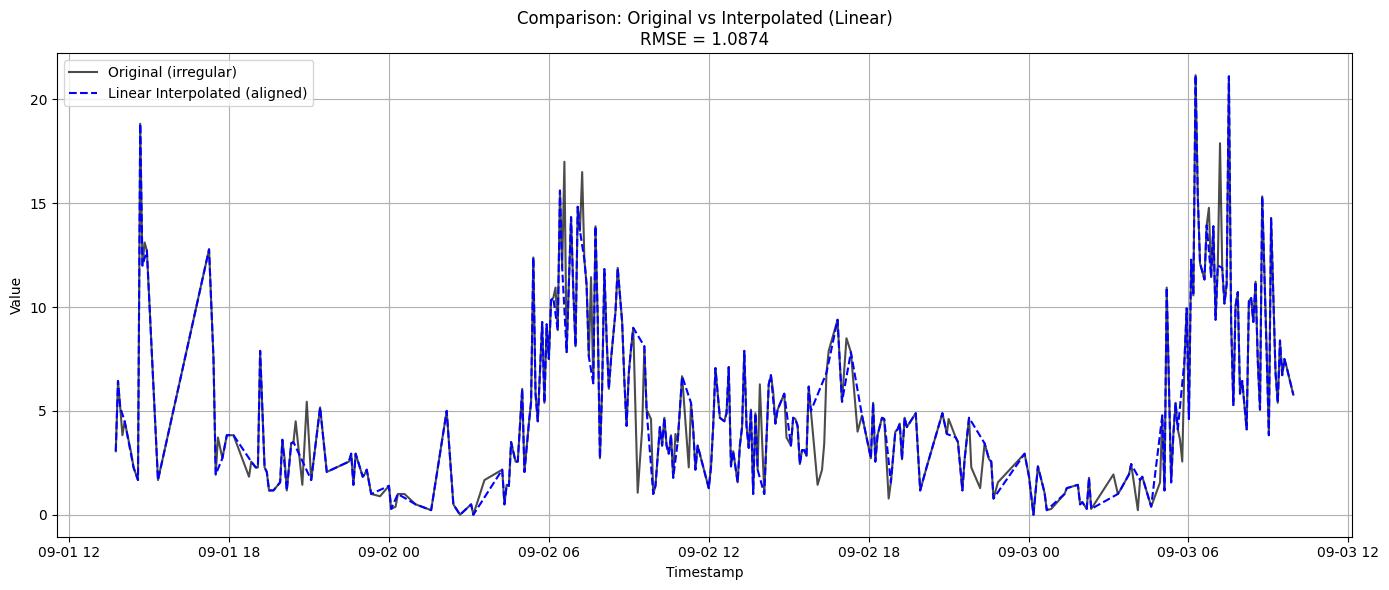

In [6]:
# Reindex the linearly interpolated series on the original irregular timestamps
# This is required because df_linear was interpolated on a regular time grid (e.g., every minute),
# and df_missing (the original data with NaNs) has irregular time intervals.
df_linear_on_original_index = df_linear.reindex(df_missing.index, method='nearest')

# Create a mask to compare only valid (non-NaN) original values and interpolated values
mask = df["value"].notna() & df_linear_on_original_index['linear'].notna()

# Compute the RMSE between the original values and the interpolated ones aligned on the same timestamps
rmse_linear_interp = np.sqrt(mean_squared_error(
    df.loc[mask, 'value'],
    df_linear_on_original_index.loc[mask, 'linear']
))

# Plot the comparison between original (irregular) and interpolated (aligned) series
plt.figure(figsize=(14, 6))

# Original signal with missing data — note: irregular time intervals
plt.plot(df_missing.index, df["value"], label="Original (irregular)", color="black", alpha=0.7)

# Interpolated signal — values have been aligned back to the original timestamps
plt.plot(df_linear_on_original_index.index, df_linear_on_original_index["linear"],
         label="Linear Interpolated (aligned)", color="blue", linestyle="--")

plt.title(f"Comparison: Original vs Interpolated (Linear~Time)\nRMSE = {rmse_linear_interp:.4f}")
plt.xlabel("Timestamp")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Additional explanation ===
# Even though we used method='linear' for interpolation,
# because the regular time grid (created with pd.date_range) had uniform time steps,
# the resulting interpolation behaves very similarly to method='time'.
# Hence, in this specific case, linear interpolation on a regular grid ≈ time-based interpolation
# when re-aligned back to the original timestamps.
